# KAFFE - Transfer Learning

In [1]:
# Import
import pathlib
import os
import datetime

import PIL
import PIL.Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# Print TensorFlow version
print(tf.__version__)

2.6.0


In [4]:
# set data directory
data_dir = './dataset/256x'
data_dir = pathlib.Path(data_dir)

In [5]:
# check image count (all sub directories)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

195


In [6]:
# set parameters
batch_size = 32
img_height = 256
img_width = 256

In [7]:
# load training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 195 files belonging to 2 classes.
Using 156 files for training.


In [8]:
# load validation set
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 195 files belonging to 2 classes.
Using 39 files for validation.


In [9]:
# check training set class names
class_names = train_ds.class_names
print(class_names)

['espresso', 'longblack']


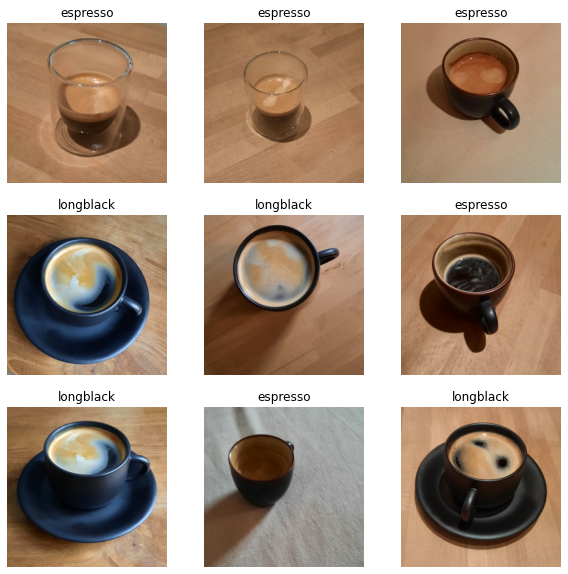

In [10]:
# check a few images from training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# set target size of the image (to feed model)
size = (150, 150)

# resize training and validation set
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [12]:
# set batch size & cache

#batch_size = 32

#train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
#validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
#test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)


In [13]:
# Data augmentation

#datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#    featurewise_center=True,
 #   featurewise_std_normalization=True,
 #   rotation_range=20,
 #   width_shift_range=0.2,
 #   height_shift_range=0.2,
 #   horizontal_flip=True,
 #   validation_split=0.2)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(train_ds)

In [14]:
# visu
#import numpy as np

#for images, labels in train_ds.take(1):
#    plt.figure(figsize=(10, 10))
#    first_image = images[0]
#    for i in range(9):
#        ax = plt.subplot(3, 3, i + 1)
#        augmented_image = data_augmentation(
#            tf.expand_dims(first_image, 0), training=True
#        )
#        plt.imshow(augmented_image[0].numpy().astype("int32"))
#        plt.title(int(labels[0]))
#        plt.axis("off")

In [15]:
# Define the base model for transfer learning
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(150, 150, 3))
x = inputs
#x = data_augmentation(inputs)  # Apply random data augmentation -- update above LINE

# Rescale input (0, 255) to a range of (-1., +1.)
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_____________________________________________

In [16]:
# define compile options
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

# set number of epochs
epochs = 20

# set callback to save logs (TensorBoard)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# train model
history = model.fit(
    train_ds,
    epochs = epochs,
    validation_data = validation_ds,
    callbacks = [tensorboard_callback])

Epoch 1/20


C:\Users\rogtr\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 9s 710ms/step - loss: 0.6613 - binary_accuracy: 0.5962 - val_loss: 0.4894 - val_binary_accuracy: 0.6667
Epoch 2/20
5/5 [==============================] - 0s 84ms/step - loss: 0.4794 - binary_accuracy: 0.8077 - val_loss: 0.3814 - val_binary_accuracy: 0.7949
Epoch 3/20
5/5 [==============================] - 0s 83ms/step - loss: 0.3742 - binary_accuracy: 0.8269 - val_loss: 0.3285 - val_binary_accuracy: 0.8205
Epoch 4/20
5/5 [==============================] - 0s 81ms/step - loss: 0.3156 - binary_accuracy: 0.9038 - val_loss: 0.2702 - val_binary_accuracy: 0.8974
Epoch 5/20
5/5 [==============================] - 0s 82ms/step - loss: 0.2486 - binary_accuracy: 0.9231 - val_loss: 0.2275 - val_binary_accuracy: 0.9231
Epoch 6/20
5/5 [==============================] - 0s 84ms/step - loss: 0.2348 - binary_accuracy: 0.9231 - val_loss: 0.2132 - val_binary_accuracy: 0.8974
Epoch 7/20
5/5 [==============================] - 0s 82ms/step - loss: 0.1951 - binary_accur

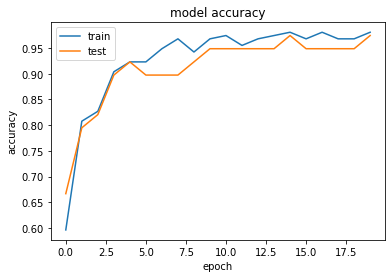

In [17]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

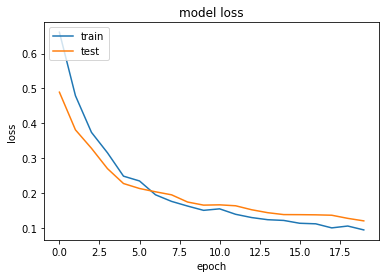

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# final round

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
____________________________________________

### BEGIN of test section

In [20]:
# helper: function to make prediction
def makePrediction(img_url):
    
    test_ds = tf.keras.utils.load_img(img_url, target_size=(150, 150))

    input_arr = tf.keras.preprocessing.image.img_to_array(test_ds)
    input_arr = np.array([input_arr])  # Convert single image to a batch.

    predictions = model.predict(input_arr)

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    
    return predictions.numpy()[0][0]

In [21]:
# define test directory
test_dir = './dataset/256x_test'
test_dir = pathlib.Path(test_dir)

# check image count (same directory)
image_list = list(test_dir.glob('*.jpg'))
image_count = len(image_list)
print(image_count)

10


In [22]:
# define list
predictions = []

# loop to make predictions
for img in image_list:
    
    print('Image:', img)
    
    result = makePrediction(img)
    predictions.append(result)


Image: dataset\256x_test\20211023_085913.jpg
Image: dataset\256x_test\20211023_124606.jpg
Image: dataset\256x_test\20211023_124707.jpg
Image: dataset\256x_test\20211024_115314.jpg
Image: dataset\256x_test\20211024_144130.jpg
Image: dataset\256x_test\20211025_083845.jpg
Image: dataset\256x_test\20211025_091348.jpg
Image: dataset\256x_test\20211025_124315.jpg
Image: dataset\256x_test\20211025_210909.jpg
Image: dataset\256x_test\20211027_123543.jpg


In [23]:
def img_load(img):
    img = os.path.join(test_dir, img)
    img = PIL.Image.open(img)
    img = img.resize((150,150))
    img = np.asarray(img)
    return img

images = os.listdir(test_dir)
img_arr = []

for image in images:
    img_arr.append(img_load(image))
    

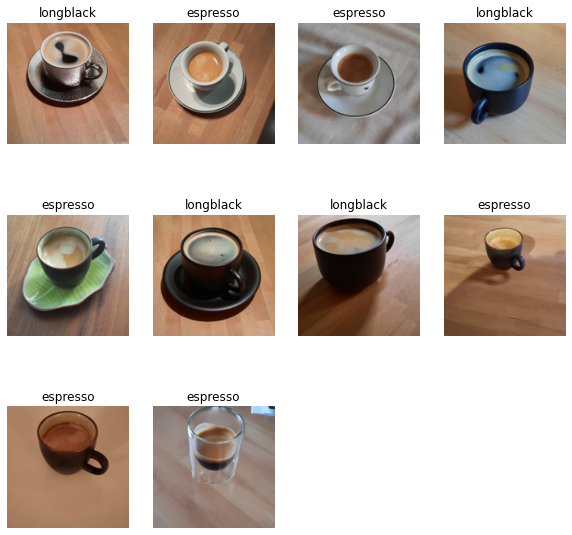

In [24]:
# define labels
labels = ['espresso', 'longblack']

# check test images & prediction label
plt.figure(figsize=(10, 10))
for i in range(len(img_arr)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(img_arr[i])
    plt.title(labels[predictions[i]])
    plt.axis("off")

In [25]:


%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 9140), started 0:03:46 ago. (Use '!kill 9140' to kill it.)